# Data Collection
First, collecting data from https://en.wikipedia.org/wiki/List_of_active_nationalist_parties_in_Europe and parse the table.

In [ ]:
import json
import requests
import wikipedia
import wikitables

def wiki_table_sanitizer (entry):
    sanitized = {}
    for key, val in entry.items():
        if type(val) == wikitables.models.Field:
            sanitized[key] = str(val)
        else:
            sanitized[key] = val
    return sanitized
            
def get_wiki_page (title, country):
    wiki_endpoint = 'https://en.wikipedia.org/w/api.php'
    payload = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'revisions',
        'rvprop': 'content',
        'utf8': 'true'
    }
    request = requests.get(wiki_endpoint, params = payload)
    print 'GET ', request.url
    data = json.loads(request.text)
    if country == 'STOP':
        return data
    try: 
        pages = data['query']['pages']
        page_id = pages.keys()[0]
        revisions = pages[page_id]['revisions'][0]['*']
        if ('#REDIRECT' in revisions):
            pattern = r'\[\[(.*?)\]\]'
            original_title =  re.findall(pattern, revisions)[0]
            print 'Redirecting to', original_title
            return get_wiki_page(original_title, country)
        try:
            wikipedia.page(title)
        except:
            augmented_title = '{} ({})'.format(title, country, title)
            return get_wiki_page(augmented_title, country)
        return data
    except KeyError:
        return data


In [16]:
# wikitables from https://github.com/bcicen/wikitables is used to 
# quickly and easily get the contents of the tables on the page

list_name = 'List of active nationalist parties in Europe'

from wikitables import import_tables
tables = import_tables(list_name)
parties = tables[0].rows
print 'Keys for every party'
for key in parties[0].keys():
    print ' - ', key
print tables[0].name 
for row in parties:
    print ' - ', row['Country'], ':', row['Party']

Keys for every party
 -  Votes
 -  % of popular vote
 -  Europarty
 -  Country
 -  Ideology, description
 -  Seats
 -  Party
 -  Date established
List of active nationalist parties in Europe[0]
 -  Hungary : Fidesz
 -  Armenia : Republican Party of Armenia
 -  Macedonia : VMRO-DPMNE
 -  Poland : Law and Justice
 -  Switzerland : Swiss People's Party
 -  Austria : Freedom Party of Austria
 -  Denmark : Danish People's Party
 -  Belgium : New Flemish Alliance
 -  Hungary : Jobbik
 -  Finland : Finns Party
 -  Italy : Lega Nord
 -  Latvia : National Alliance
 -  Norway : Progress Party
 -  Ireland : Sinn Féin
 -  France : National Front
 -  Netherlands : Party for Freedom
 -  Sweden : Sweden Democrats
 -  Germany : Alternative for Germany
 -  Russia : LDPR
 -  Norway : Centre Party
 -  Bulgaria : IMRO – Bulgarian National Movement
 -  Bulgaria : National Front for the Salvation of Bulgaria
 -  Bulgaria : Attack
 -  Slovakia : Slovak National Party
 -  Estonia : Conservative People's Party

Now that we have the contents of the table containing all the listed parties and some basic stats about them (country, number of votes etc.), we can go into the page for every party and fetch the contents. From this we'll try to parse out any non-trivial links (navigation and headers and so on) and try to build a network out of these.

In [ ]:
import re

blacklist = [
    'Category',
    'list',
    'file:',
    'wiktionary:',
    'national conservatism', 
    'european parliament election',
    'right-wing populism', 
    'far-right politics', 
    'european parliament',
    'social conservatism',
    'Right-wing populism', 
    'Far-right politics', 
#     'Euroscepticism', 
    'European Union', 
    'far-right',
    'right-wing',
    'Right-wing politics', 
    'political party',
    'baron',
]

def processLink(link):
    decoded = link.encode('utf-8')
    split = re.split(r'[(|]+', decoded)
    return split[0]

def checkLink(link):
    return any(substring.lower() in link.lower() for substring in blacklist)

def clean_links (links):
    processed = [processLink(link) for link in links]
    return [link for link in processed if not checkLink(link)]

def getWikiLinks(text):
    pattern = r'\[\[(.*?)\]\]'
    links = re.findall(pattern, text)
    return clean_links(links)

def clean_name(name):
    for ch in [' ', '-']:
        name = name.replace(ch, '_')
    for ch in [",", ".",'–']:
        name = name.replace(ch, '')
    return name.lower().decode('utf-8').encode('ascii', 'replace')

for i, party in enumerate(parties):
    party = dict(party)
    party_name = str(party['Party'])
    if '–' in party_name:
        party_name = party_name.split('–')[0]
    country = str(party['Country'])
    party_title = clean_name(party_name)
    party['title'] = party_title
    print 'Party name:', party_name, country
    try:
        page = wikipedia.page(party_name)
        party['links'] = clean_links(page.links)
        print 'Found', len(party['links']), 'links\n'
        if len(party['links']) < 20:
            print json.dumps(pages_json, indent=2)
    except Exception as e:
        print e
        try:
            pages_json = get_wiki_page(party_name, country)
            pages = pages_json['query']['pages']
            for key in pages.keys():
                text = pages[key]['revisions'][0]['*']
                party['links'] = list(set(getWikiLinks(text)))
                print 'Found', len(party['links']), 'links\n'
        except:
            try:
                pages_json = get_wiki_page(party_name, 'political party')
                pages = pages_json['query']['pages']
                for key in pages.keys():
                    text = pages[key]['revisions'][0]['*']
                    party['links'] = list(set(getWikiLinks(text)))
                    print 'Found', len(party['links']), 'links\n'
            except:
                print '--------- Failed to fetch text for', party_name, '\n'
                party['links'] = []
    parties[i] = party    


With all data collected as a list of parties with the links from their pages stored within, two graphs are constructed. One that where edges are created when a party's page's links contain another party directly (first order), and one where the edges consist of two party's that have a common link (second order). The latter will have the link stored on the edge attribute.

In [61]:
import networkx as nx

# initialize multiple directed graphs
graph_first = nx.Graph()
graph_scnd = nx.Graph()


for party in parties:
    # add nodes to both graphs
    graph_first.add_node(party['title'], **dict(wiki_table_sanitizer(party)))
    graph_scnd.add_node(party['title'], **dict(wiki_table_sanitizer(party)))

    
for i, party in enumerate(parties):
    links = party['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if graph_first.has_node(clean_link):
            graph_first.add_edge(clean_link, party['title'])
        for j, party2 in enumerate(parties):
            # add an edge if two party's pages have a link in commonn to 'second'
            if i != j:
                links2 = party2['links']
                for link2 in links2:
                    if link == link2 and not graph_scnd.has_edge(party2['title'], party['title']):
                        graph_scnd.add_edge(party2['title'], party['title'], link=clean_link)

Some very basic visualization of these graphs.

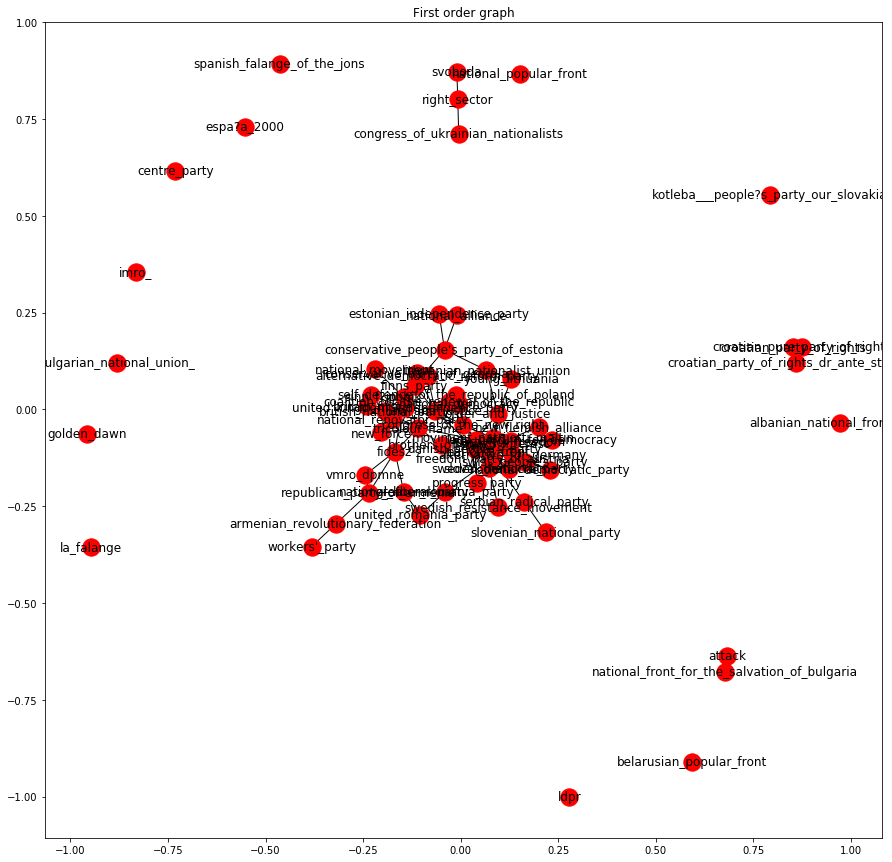

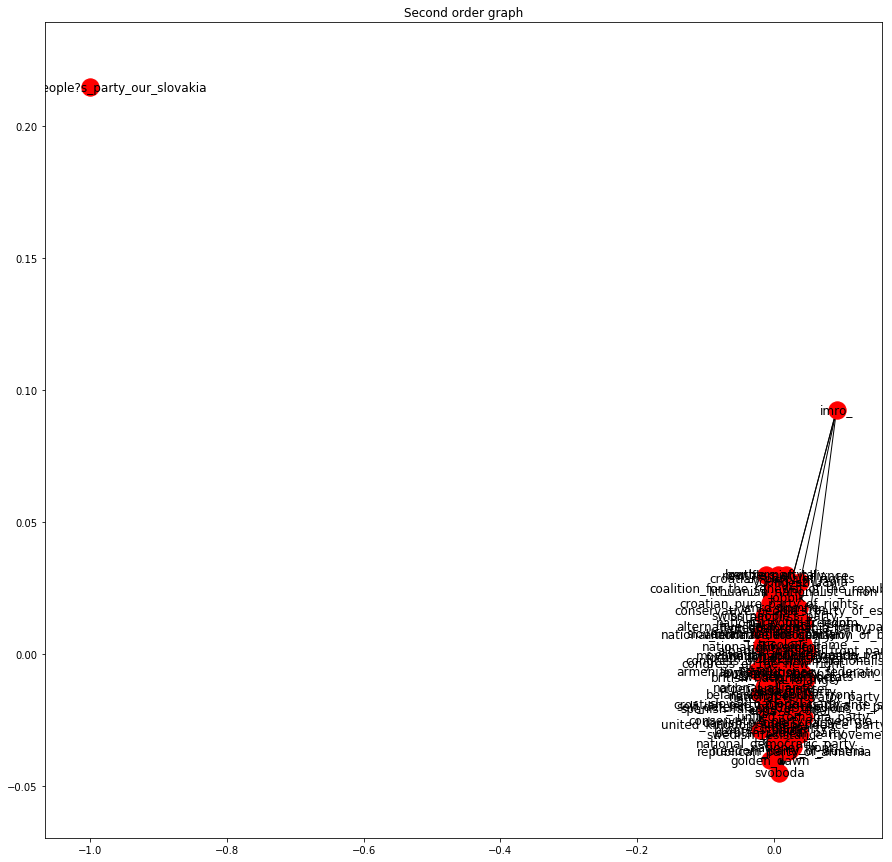

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

layout = nx.spring_layout

figure = plt.figure(figsize=(15, 15))
plt.title('First order graph')
pos = layout(graph_first)
nx.draw_networkx(graph_first, pos, with_labels=True)

figure = plt.figure(figsize=(15, 15))
pos = layout(graph_scnd)
plt.title('Second order graph')
nx.draw_networkx(graph_scnd, pos, with_labels=True)





# Basic Stats
We'll have a look at some basic stats for the graphs, like their size in terms of nodes and edges, the size of the GCC and the degree distribution.

Graph 1
Number of nodes: 70
Number of edges: 115
The average degree of the network is 3.2857142857142856
The median degree of the network is 2.0
Number of nodes in GCC: 50
Graph 2
Number of nodes: 70
Number of edges: 2184
The average degree of the network is 62.4
The median degree of the network is 65.0
Number of nodes in GCC: 69


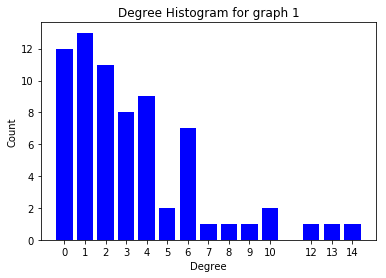

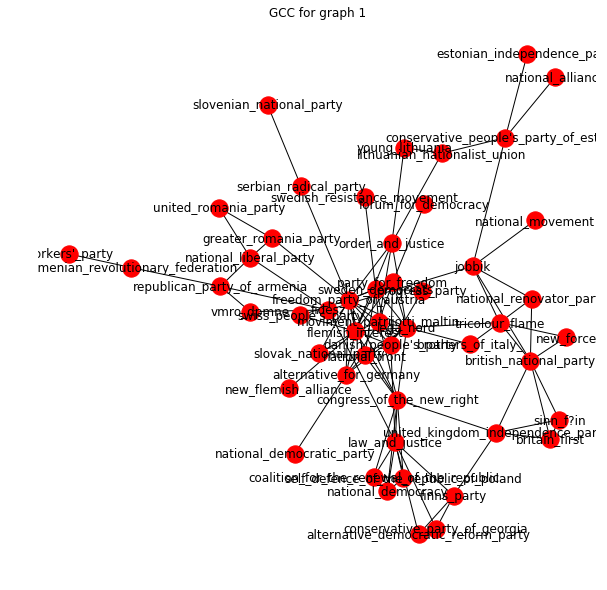

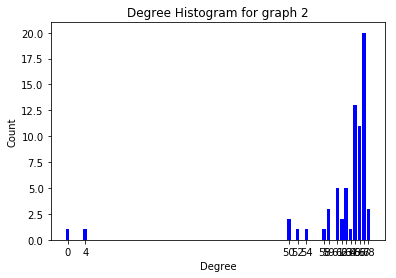

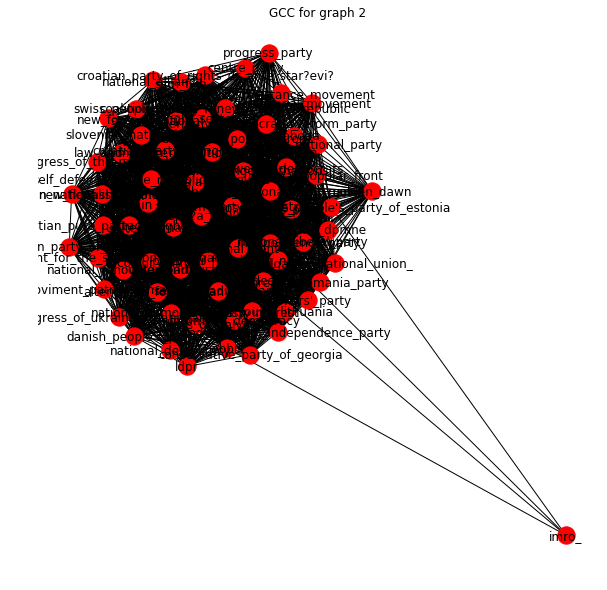

In [62]:
import numpy as np
from collections import Counter

for i, graph in enumerate([graph_first, graph_scnd]):
    print 'Graph', i + 1
    print 'Number of nodes:', len(graph.nodes)
    print 'Number of edges:', len(graph.edges)
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())    
    
    print 'The average degree of the network is', np.average(degree_sequence)
    print 'The median degree of the network is', np.median(degree_sequence)
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram for graph {}".format(i + 1))
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    G0 = Gcc[0]
    print 'Number of nodes in GCC:', len(G0.nodes)
    fig = plt.figure(figsize=(10, 10))
    plt.title('GCC for graph {}'.format(i + 1))
    pos = layout(G0)
    nx.draw(G0, pos, with_labels=True)


(u'euroscepticism', u'political_spectrum', u'international_standard_book_number', u'anti_communism', u'conservative_party_', u'digital_object_identifier')


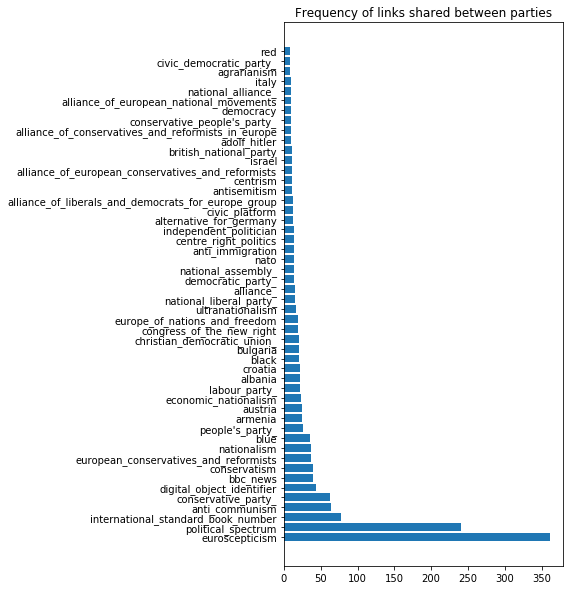

In [27]:
# linklist = map(lambda p: p['links'], parties)
# links = [link for links in linklist for link in links]

links  = sorted(nx.get_edge_attributes(graph_scnd, 'link').values())
links = [link.decode('utf-8') for link in links]
link_counts = Counter(links)


lnk, cnt = zip(*link_counts.most_common(50)) 
print lnk[0:6]
fig = plt.figure(figsize=(5, 10))

plt.barh(range(len(lnk)),cnt)
plt.yticks(range(len(lnk)),lnk)
plt.title('Frequency of links shared between parties')
plt.show()


# Color Coded Vizualization
A distinct set of colors is used for every country to color the parties taken from http://phrogz.net/css/distinct-colors.html.

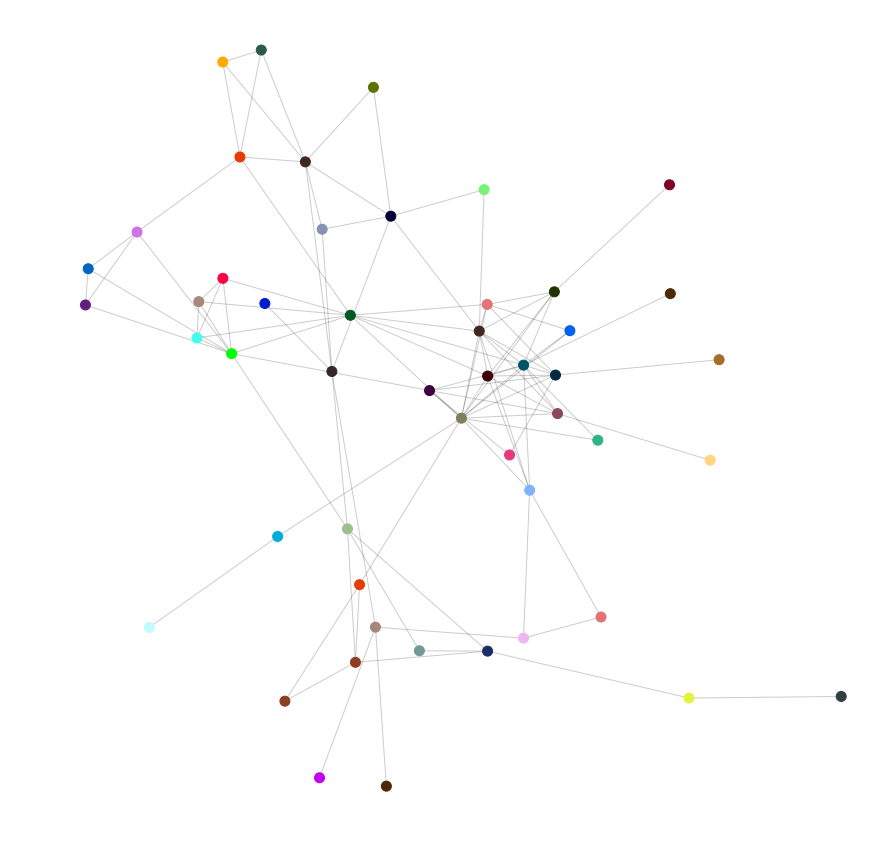

In [28]:
countries = set([str(d['Country']) for d in parties])
with open('data/colors.txt') as infile:
    colors = [s.strip() for s in infile.read().split(',')]

color_country = dict(zip(countries, colors))
def draw_color_net (graph):
    nodes = graph.nodes()

    node_colors = [color_country[str(graph.node[n]['Country'])] for n in nodes]
    fig = plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph)
    ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=colors, with_labels=True,
                                node_size=100, cmap=plt.cm.jet)
#     plt.colorbar(nc)
    plt.axis('off')
    plt.show()
    
Gcc_first = sorted(nx.connected_component_subgraphs(graph_first), key=len, reverse=True)
G0_first = Gcc_first[0]

draw_color_net(G0_first)

# Fascist Movements
Next, data is collected from https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country to complement the previous graphs. Only european movements are kept in, but for now we'll look at both acitve and inactive movements.

In [29]:
from bs4 import BeautifulSoup

# the pages are divided up per country according these lettergroups
divisions = ['A–F', 'G–M', 'N–T', 'U–Z']

# main article
fascist_list = 'List of fascist movements by country'

movements = []
# loop over 4 pages
for div in divisions:
    # get & parse HTML
    wiki = wikipedia.page('{} {}'.format(fascist_list, div))
    soup = BeautifulSoup(wiki.html(), 'html.parser')
    table = soup.find('table')
    
    # collect entries in table
    for i, row in enumerate(table.findAll("tr")):
        # first row are headers, save as keys
        if i == 0:
            keys = [ele.text.strip() for ele in row.findAll('b')]
            keys.append('link')
        
        # parse out text of the cells and save the href
        else: 
            cells = [ele.text.strip() for ele in row.findAll("td")]
            link = row.find('a')
            if link:
                link = link.get('href')
            movement = dict(zip(keys, cells + [link]))
            movements.append(movement)
            
print 'Found', len(movements), 'movements'

Found 296 movements


In [ ]:
# filter european movements
movements = filter(lambda m: any(c.lower() in m['Country of predominant operation'].lower() for c in countries), movements)

europe_mov = []
for mov in movements:
    country = mov['Country of predominant operation'].lower()
    if any(substring.lower() in country for substring in countries):
        europe_mov.append(country)
    
print 'There are', len(movements), 'movements in europe'

# fetch pages and parse links
for i, mov in enumerate(movements):
    mov['links'] = []
    try:
        page = wikipedia.page(mov['Name of movement'].encode('utf-8'))
        if page and mov['link']:
            mov['links'] = clean_links(page.links)
            print 'Found {} links for {}'.format(len(page.links), mov['Name of movement'].encode('utf-8'))
    except:
        print 'Failed to collect for {}'.format(mov['Name of movement'].encode('utf-8'))
    movements[i] = mov


In [31]:
# graphs
fascist_first = nx.Graph()
fascist_biparte = nx.Graph()

for mov in movements:
    mov['title'] = clean_name(mov['Name of movement'].encode('utf-8'))
    # add nodes to both graphs
    fascist_first.add_node(mov['title'], **dict(mov))
    fascist_biparte.add_node(mov['title'], **dict(mov))

    
for i, mov in enumerate(movements):
    links = mov['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if fascist_first.has_node(clean_link):
            fascist_first.add_edge(clean_link, mov['title'])
        for j, mov2 in enumerate(movements):
            # add an edge if two party's pages have a link in commonn to 'second'
            if i != j:
                links2 = mov2['links']
                for link2 in links2:
                    if link == link2 and not fascist_biparte.has_edge(mov2['title'], mov['title']):
                        fascist_biparte.add_edge(mov2['title'], mov['title'], link=clean_link)



Graph 1
Number of nodes: 176
Number of edges: 1886
The average degree of the network is 21.431818181818183
The median degree of the network is 20.0
Number of nodes in GCC: 148
Graph 2
Number of nodes: 176
Number of edges: 11935
The average degree of the network is 135.625
The median degree of the network is 154.0
Number of nodes in GCC: 163


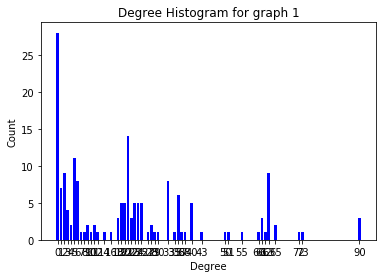

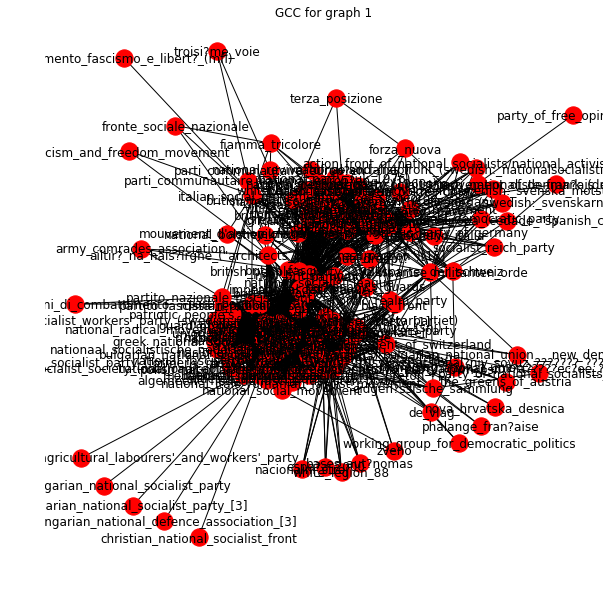

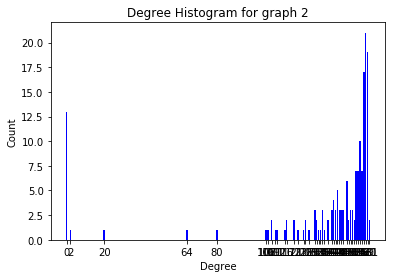

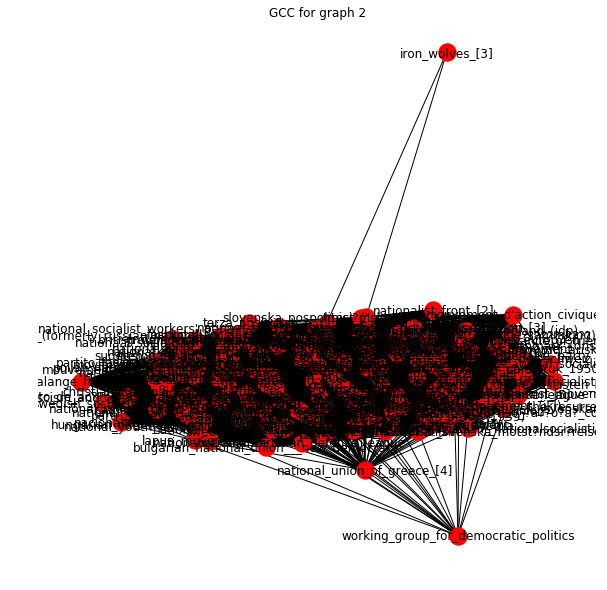

In [32]:
for i, graph in enumerate([fascist_first, fascist_biparte]):
    print 'Graph', i + 1
    print 'Number of nodes:', len(graph.nodes)
    print 'Number of edges:', len(graph.edges)
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())    
    
    print 'The average degree of the network is', np.average(degree_sequence)
    print 'The median degree of the network is', np.median(degree_sequence)
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram for graph {}".format(i + 1))
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    G0 = Gcc[0]
    print 'Number of nodes in GCC:', len(G0.nodes)
    fig = plt.figure(figsize=(10, 10))
    plt.title('GCC for graph {}'.format(i + 1))
    pos = layout(G0)
    nx.draw(G0, pos, with_labels=True)

(u'1934_montreux_fascist_conference', u'adolf_hitler', u'afrikaner_weerstandsbeweging', u'british_fascists', u'a_k_chesterton', u'anti_communism')


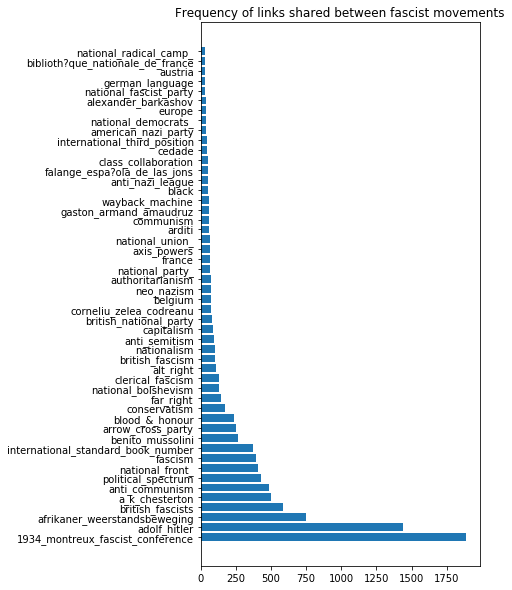

In [33]:
links  = sorted(nx.get_edge_attributes(fascist_biparte, 'link').values())
links = [link.decode('utf-8') for link in links]
link_counts = Counter(links)


lnk, cnt = zip(*link_counts.most_common(50)) 
print lnk[0:6]
fig = plt.figure(figsize=(5, 10))

plt.barh(range(len(lnk)),cnt)
plt.yticks(range(len(lnk)),lnk)
plt.title('Frequency of links shared between fascist movements')
plt.show()

# Build Network in Neo4j

Neo4j is used to build out a network structure that is provides a more expressive and flexible query language that we can leverage to explore the structure of the collected data. Nodes in this network are both the found 'Party's and the 'Movement's and edges ('LINKS_TO' relations) are created between all of these if their page links to either a 'Movement' or a 'Party'. With the query language Cypher we can then easily run queries on the network.

In [150]:
from neo4j.v1 import GraphDatabase

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "dodadoda"))

def add_party(tx, party):
    seats_total = total=party['Seats'].split()
    if len(seats_total) == 3:
        seats = seats_total[0]
        total = seats_total[1]
    else:
        seats = 'none'
        total = 'none'
    
    return tx.run("MERGE (a:Node:Party {title: $title, name: $name, country: $country, votes: $votes, "
           "seats: $seats, total: $total, established: $established})",
           name=party['Party'], title=party['title'], country=party['Country'], votes=party['Votes'],
          seats=seats, total=total, established=party['Date established'])

def add_movement(tx, movement):
    try:
        influence = movement['General influence']
    except KeyError:
        influence = 'none'
    return tx.run("MERGE (b:Node:Movement {title: $title, name: $name, country: $country, active: $active, influence: $influence})",
                 name=movement['Name of movement'], title=movement['title'], 
                  country=movement['Country of predominant operation'], 
                  active=movement['Active?'], influence=influence)
    
def add_link(tx, node, link):
    link = clean_name(link)
    # add an edge if a page of one party mentions another to 'first'
    result = tx.run('MATCH (n), (m) WHERE n.title = $title_a AND m.title = $title_b MERGE (n)-[:LINKS_TO]->(m)', 
           title_a=node, title_b=link)
    
def find_node(tx, name, type_):
    title = clean_name(name)
    return list(tx.run("MATCH (a:{}) WHERE a.title = $title RETURN a.title AS title".format(type_),title=title))


with driver.session() as session:
    # add party nodes
    for party in parties:
        session.write_transaction(add_party, wiki_table_sanitizer(party))
    print 'Added {} parties to network'.format(len(list(parties)))
    
    # add movement nodes
    for mov in movements:
        session.write_transaction(add_movement, mov)
    print 'Added {} movements to network'.format(len(movements))
    
    # look up the links from all parties within network and create edges
    for party in parties:
        for link in party['links']:
            parties = session.read_transaction(find_node, link, 'Party')
            if len(parties) > 0:
                session.write_transaction(add_link, wiki_table_sanitizer(party)['title'], link)
            movs = session.read_transaction(find_node, link, 'Movement')
            if len(movs) > 0:
                session.write_transaction(add_link, wiki_table_sanitizer(party)['title'], link)
    
    # look up links from all movements within network and create edges
    for mov in movements:
        for link in mov['links']:
            parties = session.read_transaction(find_node, link, 'Party')
            if len(parties) > 0:
                session.write_transaction(add_link, mov['title'], link)
            movs = session.read_transaction(find_node, link, 'Movement')
            if len(movs) > 0:
                session.write_transaction(add_link, mov['title'], link)


Added 0 parties to network
Added 177 movements to network


# Network Analysis

## Nodes & Edges
Now that all the network data is stored in one central place, Neo4j is used to look at some statistics about the network. First, we look at some basic stats about the nodes and edges in the network:


In [248]:
with driver.session() as session:
    print 'General Stats'
    # number of nodes
    result = session.run("MATCH (n:Node) RETURN count(n)")
    values = result.value()
    print 'There are {} Nodes in the network'.format(values[0])
    
    # number of edges
    result = session.run("MATCH (n:Node)-[r:LINKS_TO]->(m:Node) RETURN count(r)")
    values = result.value()
    print  'There are {} links between Nodes in the network'.format(values[0])
    
    result = session.run("MATCH (n:Party)-[r:LINKS_TO]->(m:Movement) RETURN n, r, m")
    records = list(result.records())
    n, r, m = set(), set(), set()
    for rec in records: 
        n.add(rec['n'])
        r.add(rec['r'])
        m.add(rec['m'])
    print 'There are {} "Party" nodes linking to {} "Movement" nodes through {} edges'.format( len(n), len(m), len(r))
    
    result = session.run("MATCH (n:Movement)-[r:LINKS_TO]->(m:Party) RETURN n, r, m")
    records = list(result.records())
    n, r, m = set(), set(), set()
    for rec in records: 
        n.add(rec['n'])
        r.add(rec['r'])
        m.add(rec['m'])
    print 'There are {} "Movement" nodes linking to {} "Party" nodes through {} edges'.format( len(n), len(m), len(r))
    
    print '\nParties Stats'
    # number of nodes
    result = session.run("MATCH (n:Party) RETURN count(n)")
    values = result.value()
    print 'There are {} "Party" nodes in the network'.format(values[0])
    
    # number of edges
    result = session.run("MATCH (n:Party)-[r:LINKS_TO]->(m:Party) RETURN count(r)")
    values = result.value()
    print  'There are {} links between "Party" nodes in the network'.format(values[0])
    
    print '\nMovements Stats'
    # number of nodes
    result = session.run("MATCH (n:Movement) RETURN count(n)")
    values = result.value()
    print 'There are {} "Movement" nodes in the network'.format(values[0])
    
    # number of edges
    result = session.run("MATCH (n:Movement)-[r:LINKS_TO]->(m:Movement) RETURN count(r)")
    values = result.value()
    print  'There are {} links between "Movement" nodes in the network'.format(values[0])
    
    

General Stats
There are 247 Nodes in the network
There are 2553 links between Nodes in the network
There are 3 "Party" nodes linking to 23 "Movement" nodes through 43 edges
There are 85 "Movement" nodes linking to 23 "Party" nodes through 171 edges

Parties Stats
There are 70 "Party" nodes in the network
There are 149 links between "Party" nodes in the network

Movements Stats
There are 177 "Movement" nodes in the network
There are 2190 links between "Movement" nodes in the network


## Centrality Measures
### Degree Distribution

Next, we will consider a series of stats that express the connectednes of the entities in our network. First, we look at the in- and outdegree of the nodes, for the network as a whole and for the Party & Movement network seperatetly. This shows how many pages link to a Party or Movement, and to how many other nodes the page of a node links, respectively. 

In [263]:
variables = [{
    'entity': 'Node',
    'text': 'General Stats'
}, {
    'entity': 'Party',
    'text': 'Parties Stats'
}, {
    'entity': 'Movement',
    'text': 'Movements Stats'
}]

with driver.session() as session:
    for net in variables:
        print '\n' + net['text']
        print 'In-Degree'
        result = session.run("MATCH (l:{}) RETURN l.name as Name, l.country as Country, size ((l)<-[:LINKS_TO]-())"
                             "AS in_degree ORDER BY in_degree DESC limit 10".format(net['entity']))
        for rec in result.records():
            print ' - {}, {}: {}'.format(rec['Name'].encode('utf-8'), rec['Country'], rec['in_degree'])
        
        print '\nOut-Degree'
        result = session.run("MATCH (l:{}) RETURN l.name as Name, l.country as Country, size ((l)-[:LINKS_TO]->())"
                             "AS out_degree ORDER BY out_degree DESC limit 10".format(net['entity']))
        for rec in result.records():
            print ' - {}, {}: {}'.format(rec['Name'].encode('utf-8'), rec['Country'], rec['out_degree'])
    


General Stats
In-Degree
 - National Fascisti, United Kingdom: 87
 - Imperial Fascist League, United Kingdom: 87
 - British Union of Fascists, United Kingdom: 87
 - Iron Guard, Romania: 72
 - Arrow Cross Party, Hungary: 68
 - National Corporate Party, Ireland: 61
 - Romanian Front, Romania: 60
 - National-Christian Defense League, Romania: 60
 - Crusade of Romanianism, Romania: 60
 - Lapua Movement, Finland: 60

Out-Degree
 - National Socialist League, United Kingdom: 40
 - Groupe Charles Martel, France: 40
 - Party of National Unity (SNJ), Czechoslovakia: 40
 - British Fascisti, United Kingdom: 39
 - National Socialist Society (Natsional-sotsialisticheskoye obshchestvo, NSO, нaциoнaл-coциaлстичecкoe общество, HCO), Russia: 38
 - Polish National Community-Polish National Party (PWN-PSN), Poland: 38
 - German Union for Western Poland (DV), Poland: 38
 - Russian National Socialist Party (formerly Russian National Union) (Russkiy Natsionalʼniy Soyuz Русский Национальний Союз), Russia: 38


Then, we will look at the betweenness centrality of the Party's and Movements, which expresses how much information flows through a node by looking at how many shortest paths of the whole network pass through it. The algrothms have been run within the Neo4j browser using https://neo4j-contrib.github.io/neo4j-graph-algorithms/ and cached on the graph model within the database.

In [285]:
with driver.session() as session:
    result = session.run("MATCH (l:Party) "
    "WHERE EXISTS (l.all_party_betweenness) "
    "RETURN l.name as name, l.country as country, l.all_party_betweenness as betweenness, "
    "toFloat(l.seats) / toFloat(l.total) as fraction "
    "ORDER BY betweenness DESC "
    "LIMIT 10")
    
    for rec in result.records():
        print '{}, {} - centrality: {} - fraction {}'.format(rec['name'], rec['country'], rec['betweenness'], rec['fraction'])

Law and Justice, Poland - centrality: 476.5 - fraction 0.510869565217
Jobbik, Hungary - centrality: 413.0 - fraction 0.130653266332
Fidesz, Hungary - centrality: 412.0 - fraction 0.673366834171
Lega Nord, Italy - centrality: 354.0 - fraction 0.198412698413
Tricolour Flame, Italy - centrality: 337.0 - fraction 0.0
Freedom Party of Austria, Austria - centrality: 288.333333333 - fraction 0.27868852459
Congress of the New Right, Poland - centrality: 196.0 - fraction 0.0
British National Party, United Kingdom - centrality: 159.0 - fraction 0.0
Danish People's Party, Denmark - centrality: 136.0 - fraction 0.206703910615
Greater Romania Party, Romania - centrality: 51.0 - fraction 0.0
